# 1. 국토교통부 실거래가 공개시스템 데이터 분석
- 대상 데이터 - 아파트(매매) 실거래가 2025년 12월 1달 기준
- 본 분석에서는 ㎡당 가격 기준으로 지역별 주택 가격 수준을 비교하기 위해 아파트 매매 실거래가 데이터를 우선적으로 활용
- 고려사항
    - **실제 청년층의 주거 이동은 아파트 매매에 국한되지 않으며, 전·월세 거래, 연립·다세대, 오피스텔, 단독·다가구 주택 등 다양한 주택 유형과 거래 형태가 혼재되어 있어, 이를 고려하여 이후 분석에서는 거래 유형 및 주택 유형을 확장할 필요가 있음.**

In [ ]:
import pandas as pd

df = pd.read_csv(
    "./data/아파트(매매)_실거래가_202512_20260128.csv",
    encoding="cp949",
    sep=",",
    skiprows=15,
    engine="python"
)

df.head()

,NO,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),동,층,매수자,매도자,건축년도,도로명,해제사유발생일,거래유형,중개사소재지,등기일자
0,1,전북특별자치도 전주시 완산구 효자동3가,1482-1,1482,1,서곡주공,59.890,202512,31,"16,000",-,11,개인,개인,2000,서곡로 8,-,직거래,-,-
1,2,충청남도 아산시 온천동,1935,1935,0,아산온천미소지움아파트,59.963,202512,31,"17,750",-,8,개인,개인,2017,아산로 116-20,-,중개거래,충남 아산시,-
2,3,경상남도 진주시 판문동,269-13,269,13,현대,84.945,202512,31,"16,500",-,10,기타,개인,1992,진양호로51번길 6-7,-,중개거래,경남 진주시,-
3,4,경상북도 김천시 신음동,394-3,394,3,현대1,59.969,202512,31,"10,400",-,1,개인,개인,1997,시청로 46,-,중개거래,경북 김천시,-
4,5,전북특별자치도 전주시 완산구 효자동1가,418,418,0,현대,70.470,202512,31,"16,500",-,7,개인,개인,1990,용머리로 20,-,중개거래,전북 전주시 완산구,-


In [7]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 42753 entries, 0 to 42752
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   NO        42753 non-null  int64  
 1   시군구       42753 non-null  str    
 2   번지        42753 non-null  str    
 3   본번        42753 non-null  int64  
 4   부번        42753 non-null  int64  
 5   단지명       42753 non-null  str    
 6   전용면적(㎡)   42753 non-null  float64
 7   계약년월      42753 non-null  int64  
 8   계약일       42753 non-null  int64  
 9   거래금액(만원)  42753 non-null  str    
 10  동         42753 non-null  str    
 11  층         42753 non-null  int64  
 12  매수자       42753 non-null  str    
 13  매도자       42753 non-null  str    
 14  건축년도      42753 non-null  int64  
 15  도로명       42753 non-null  str    
 16  해제사유발생일   42753 non-null  str    
 17  거래유형      42753 non-null  str    
 18  중개사소재지    42753 non-null  str    
 19  등기일자      42753 non-null  str    
dtypes: float64(1), int64(7), str(12)
memory

In [8]:
df.describe()

,NO,본번,부번,전용면적(㎡),계약년월,계약일,층,건축년도
count,42753.000000,42753.000000,42753.000000,42753.000000,42753.0,42753.000000,42753.000000,42753.000000
mean,21377.000000,842.015788,3.304446,74.305249,202512.0,15.633523,10.349660,2006.668865
std,12341.872366,763.059128,26.555912,23.703568,0.0,8.926246,7.151791,11.215980
min,1.000000,0.000000,0.000000,12.010000,202512.0,1.000000,1.000000,1962.000000
25%,10689.000000,372.000000,0.000000,59.840000,202512.0,8.000000,5.000000,1997.000000
50%,21377.000000,716.000000,0.000000,78.620000,202512.0,16.000000,9.000000,2006.000000
75%,32065.000000,1103.000000,1.000000,84.957200,202512.0,23.000000,14.000000,2017.000000
max,42753.000000,7346.000000,1653.000000,273.960000,202512.0,31.000000,63.000000,2025.000000


In [4]:
# 거래금액 전처리 str -> int
df["거래금액(만원)"] = (
    df["거래금액(만원)"]
    .str.replace(",", "", regex=False)
    .astype(int)
)

In [5]:
# 컬럼 신규 생성
df["㎡당가격"] = df["거래금액(만원)"] / df["전용면적(㎡)"]

In [6]:
# “청년 이동” 분석인데 84㎡, 120㎡ 섞이면 논리 무너짐
df_young = df[
    (df["전용면적(㎡)"] >= 40) &
    (df["전용면적(㎡)"] <= 60)
].copy()

In [7]:
# 시군구까지만
df_young["시군구_정제"] = (
    df_young["시군구"]
    .str.split()
    .str[:3]
    .str.join(" ")
)

In [8]:
# 지역별 주거비 대표값 생성
region_price = (
    df_young
    .groupby("시군구_정제")
    .agg(
        평균거래금액=("거래금액(만원)", "mean"),
        평균_면적당가격=("㎡당가격", "mean"),
        거래건수=("NO", "count")
    )
    .reset_index()
)

region_price = region_price.rename(columns={
    "avg_price": "평균거래금액",
    "avg_price_per_m2": "평균_㎡당가격",
    "cnt": "거래건수"
})

In [9]:
df.head()

,NO,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),...,층,매수자,매도자,건축년도,도로명,해제사유발생일,거래유형,중개사소재지,등기일자,㎡당가격
0,1,전북특별자치도 전주시 완산구 효자동3가,1482-1,1482,1,서곡주공,59.890,202512,31,16000,...,11,개인,개인,2000,서곡로 8,-,직거래,-,-,267.156453
1,2,충청남도 아산시 온천동,1935,1935,0,아산온천미소지움아파트,59.963,202512,31,17750,...,8,개인,개인,2017,아산로 116-20,-,중개거래,충남 아산시,-,296.015876
2,3,경상남도 진주시 판문동,269-13,269,13,현대,84.945,202512,31,16500,...,10,기타,개인,1992,진양호로51번길 6-7,-,중개거래,경남 진주시,-,194.243334
3,4,경상북도 김천시 신음동,394-3,394,3,현대1,59.969,202512,31,10400,...,1,개인,개인,1997,시청로 46,-,중개거래,경북 김천시,-,173.422935
4,5,전북특별자치도 전주시 완산구 효자동1가,418,418,0,현대,70.470,202512,31,16500,...,7,개인,개인,1990,용머리로 20,-,중개거래,전북 전주시 완산구,-,234.142188


In [10]:
# 지역별 평균 ㎡당 가격 분포
region_price["평균_면적당가격"].describe()

count    1434.000000
mean      558.985055
std       686.053503
min        28.323597
25%       191.575172
50%       313.379609
75%       599.018666
max      8173.269308
Name: 평균_면적당가격, dtype: float64

In [11]:
# 거래건수 필터링
region_price_f = region_price[region_price["거래건수"] >= 30]

In [12]:
# ㎡당 가격 기준 상위 10
cheap_top10 = region_price_f.sort_values("평균_면적당가격").head(10)
cheap_top10

,시군구_정제,평균거래금액,평균_면적당가격,거래건수
1174,전라남도 광양시 중동,5956.666667,103.010821,42
1226,전라남도 영암군 삼호읍,6242.352941,105.379570,34
544,경상북도 포항시 남구,9272.796610,159.616574,59
1208,전라남도 순천시 조례동,9436.111111,165.669590,36
545,경상북도 포항시 북구,10948.235294,189.390322,51
579,광주광역시 북구 문흥동,11170.000000,196.159768,30
350,경상남도 김해시 외동,12878.378378,222.481429,37
509,경상북도 안동시 송현동,11332.815126,224.160887,119
419,경상남도 창원시 진해구,13240.789474,226.459653,38
1420,충청북도 청주시 상당구,13528.196721,235.680236,61


In [13]:
# ㎡당 가격 기준 하위 10
expensive_top10 = region_price_f.sort_values("평균_면적당가격", ascending=False).head(10)
expensive_top10

,시군구_정제,평균거래금액,평균_면적당가격,거래건수
981,서울특별시 양천구 신정동,129456.000000,2373.931753,50
148,경기도 성남시 분당구,110049.562500,2077.905438,64
871,서울특별시 관악구 봉천동,87245.000000,1471.276998,40
150,경기도 성남시 중원구,75009.166667,1316.317657,60
323,경기도 화성시 청계동,74835.294118,1256.558636,34
891,서울특별시 노원구 월계동,68220.588235,1218.194455,34
184,경기도 안양시 동안구,65273.410405,1187.990918,173
316,경기도 화성시 영천동,67219.444444,1149.856872,36
93,경기도 광명시 철산동,63681.578947,1149.037052,38
224,경기도 용인시 수지구,66821.608392,1129.593475,143


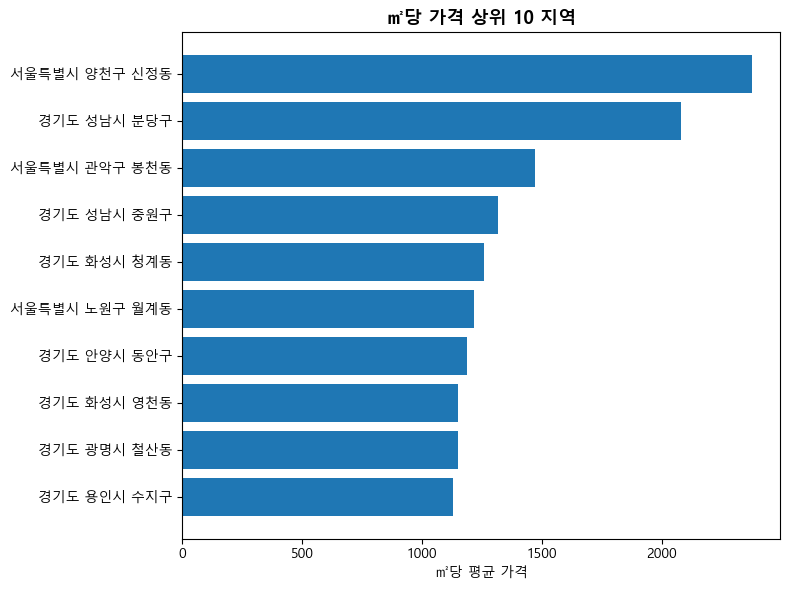

In [18]:
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

# 정렬 (낮은 값 → 위, 높은 값 → 아래)
plot_df = expensive_top10.sort_values("평균_면적당가격")

plt.figure(figsize=(8, 6))
plt.barh(
    plot_df["시군구_정제"],
    plot_df["평균_면적당가격"]
)

plt.title("㎡당 가격 상위 10 지역", fontsize=13, fontweight="bold")
plt.xlabel("㎡당 평균 가격")
plt.ylabel("")

plt.tight_layout()
plt.show()

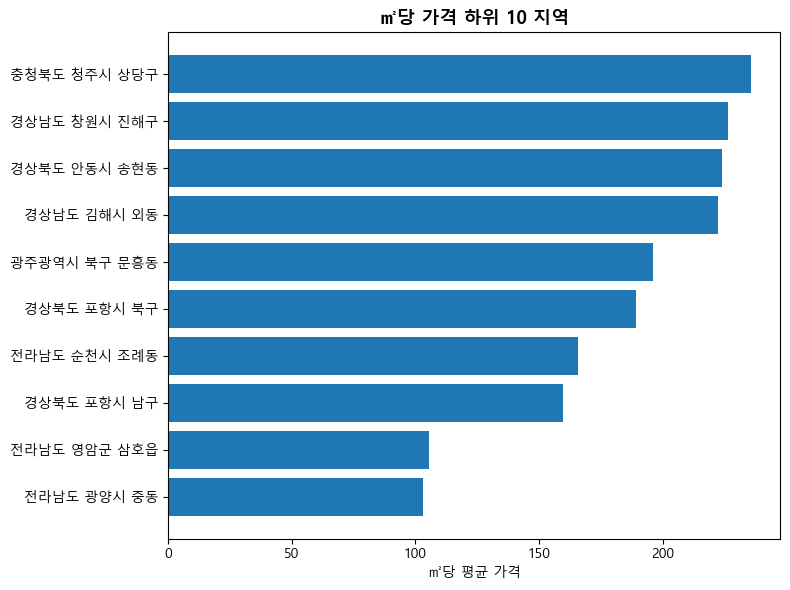

In [20]:
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

# 정렬 (낮은 값 → 위, 높은 값 → 아래)
plot_df = cheap_top10.sort_values("평균_면적당가격")

plt.figure(figsize=(8, 6))
plt.barh(
    plot_df["시군구_정제"],
    plot_df["평균_면적당가격"]
)

plt.title("㎡당 가격 하위 10 지역", fontsize=13, fontweight="bold")
plt.xlabel("㎡당 평균 가격")
plt.ylabel("")

plt.tight_layout()
plt.show()